# A toy example of using softDTW as a loss


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from tslearn.datasets import CachedDatasets
from tslearn.metrics import SoftDTWLossPyTorch

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

X_subset = X_train[y_train < 4]
np.random.shuffle(X_subset)
X_subset = X_subset[:50]

**Question.** Plot the time series in the dataset.

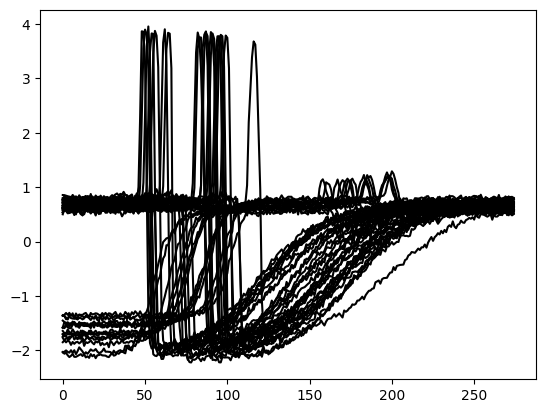

In [6]:
for ts in X_subset:
    plt.plot(ts[:, 0], color='k')

**Question.** In the following, we will try to predict the end of the time series based on the first 50 time points. What do you observe? Prepare a dataloader for this forecasting problem.

In [7]:
threshold = 50
X_input = torch.tensor(X_subset[:, :threshold], dtype=torch.float32)
y_target = torch.tensor(X_subset[:, threshold:], dtype=torch.float32)

batch_size = 16
train_ds = TensorDataset(X_input, y_target)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

**Question.** Now, compare two MLP models for the forecasting task at hand, using the same architecture for both models, but optimizing one on MSE and the other on softDTW.
Compare the forecast quality, both qualitatively and quantitatively.

MSE-trained model MSE: 0.3497
softDTW-trained model MSE (eval metric is MSE): 0.7979


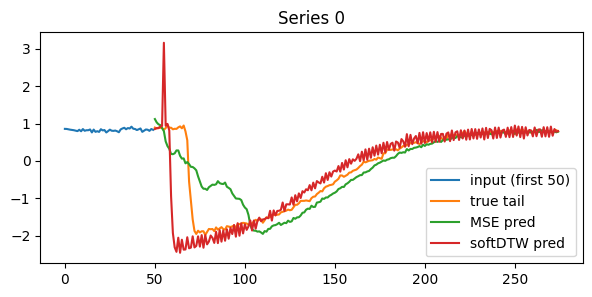

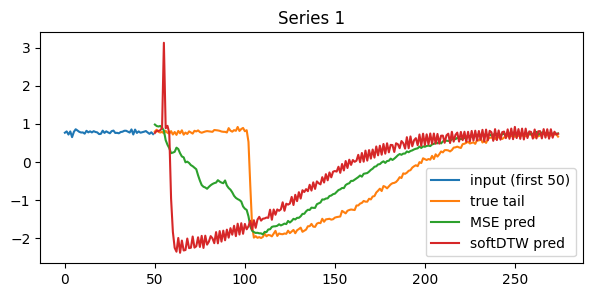

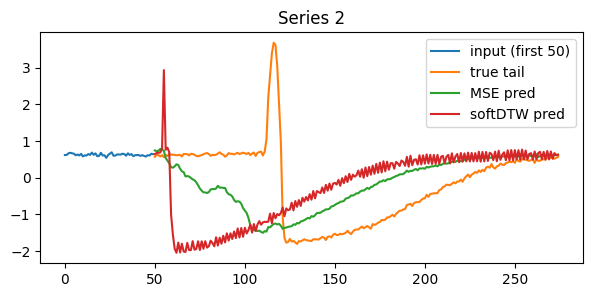

In [8]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = x.squeeze(-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.unsqueeze(dim=-1)


mse_model = SimpleMLP(threshold, 256, 275 - threshold)
sdtw_model = SimpleMLP(threshold, 256, 275 - threshold)


def train_model(model, loader, criterion, epochs=200, lr=1e-3, device="cpu"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            if isinstance(criterion, torch.nn.MSELoss):
                loss = criterion(pred.squeeze(-1), yb.squeeze(-1))
            else:
                loss = criterion(pred, yb).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())
    return losses


mse_losses = train_model(mse_model, train_loader, torch.nn.MSELoss(), epochs=200, lr=1e-3)
sdtw_losses = train_model(
    sdtw_model,
    train_loader,
    SoftDTWLossPyTorch(gamma=0.1, normalize=True),
    epochs=200,
    lr=1e-3,
)


def evaluate(model):
    model.eval()
    with torch.no_grad():
        preds = model(X_input).squeeze(-1).numpy()
    mse = np.mean((preds - y_target.squeeze(-1).numpy()) ** 2)
    return preds, mse


mse_pred, mse_score = evaluate(mse_model)
sdtw_pred, sdtw_score = evaluate(sdtw_model)

print(f"MSE-trained model MSE: {mse_score:.4f}")
print(f"softDTW-trained model MSE (eval metric is MSE): {sdtw_score:.4f}")

# Qualitative comparison on a few series
for idx in [0, 1, 2]:
    plt.figure(figsize=(7, 3))
    plt.plot(range(threshold), X_subset[idx, :threshold, 0], label=f"input (first {threshold})")
    plt.plot(range(threshold, 275), y_target[idx, :, 0], label="true tail")
    plt.plot(range(threshold, 275), mse_pred[idx], label="MSE pred")
    plt.plot(range(threshold, 275), sdtw_pred[idx], label="softDTW pred")
    plt.legend()
    plt.title(f"Series {idx}")
    plt.show()